In [1]:
import multiprocessing
from itertools import chain

# NLP 모듈 
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from eunjeon import Mecab
import eunjeon
import konlpy
import nltk

# numpy & pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from scipy.stats import truncnorm

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Embedding, Activation, LSTM, Bidirectional, GRU, Softmax, Dropout
from keras.preprocessing.sequence import pad_sequences

# my lib
import textlib as tl

In [22]:
WORKERS = multiprocessing.cpu_count() - 1

UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'

In [3]:
# gensim으로 word2vec 훈련 중 epoch마다 loss를 확인할 수 있는 callback
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.loss_previous_step = 0

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print(f'Loss after epoch {self.epoch}: {loss - self.loss_previous_step}')
        self.epoch += 1
        self.loss_previous_step = loss        

In [61]:
class Word2VecModel(object):
    def __init__(self):
        pass
    
    def load(self, model_file_name):
        # load
        self.gensim_w2v_model = Word2Vec.load(model_file_name)
        # 후처리
        self._post_model_created();
        
    def create(self, in_corpus_file_name, out_model_file_name,
               max_vocab_size=10000, embedding_size=100,
               epochs=10, window=5, workers=3):
        # input파일에서 말뭉치 추출
        corpus = [sentence.strip().split(' ') 
                  for sentence in open(in_corpus_file_name, 'r', encoding='utf-8').readlines()]
        # 빈도수 상위 n위의 최소빈도수 구함 (word2vec 훈련 시 그 이하는 버리기 위함)
        min_freq_cnt = self._get_min_freq_count(corpus, max_vocab_size)
        print(f'{max_vocab_size}개의 단어 내에서 최소 빈도수는 {min_freq_cnt}입니다.')

        loss_logger = LossLogger()
        # gensim word2vec call
        self.gensim_w2v_model = Word2Vec(corpus, 
                         size=embedding_size, 
                         workers=workers, 
                         min_count=min_freq_cnt,
                         sg=1, 
                         iter=epochs,
                         callbacks=[loss_logger],
                         compute_loss=True,
                         window=window)
        # 저장
        self.gensim_w2v_model.save(out_model_file_name)   
        # 후처리
        self._post_model_created()        
        
    def _post_model_created(self):
        self.vocab_size = self.gensim_w2v_model.wv.vectors.shape[0]
        self.embedding_size = self.gensim_w2v_model.wv.vectors.shape[1]
        self.index2word = self.gensim_w2v_model.wv.index2word
        # unk, pad 추가
        self.index2word.append( UNK_TOKEN )
        self.index2word.append( PAD_TOKEN )    
        
        self.weight = self.gensim_w2v_model.wv.vectors
        self._append_unk_pad_vectors()
        
        # cosine유사도 체크를 위해 normalize
        self.norm_weight = normalize(self.weight, norm='l2', axis=1)

        # word를 index로 변환
        self.word2index = {w:i for i, w in enumerate(self.index2word)}
        # 사전. word를 vector로 변환 - 안쓰네
        #self.dictionary = {w:v for w, v in zip(self.index2word, unit_w2v)}    
        
    def _get_truncated_normal(self, mean=0, sd=1, low=-1, upp=1):
        return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )
        
    # unknown, padding 토큰 추가
    def _append_unk_pad_vectors(self):
        self.weight = np.append(self.weight, 
                         self._get_truncated_normal().rvs(self.embedding_size * 2).reshape(2, self.embedding_size), axis=0)            
        
    # 빈도수 상위 vocab_size 내에 존재하는 단어 중 최소 빈도수를 구함
    def _get_min_freq_count(self, sentences, max_freq_rank):
        fdist = nltk.FreqDist(chain.from_iterable(sentences))
        return fdist.most_common(max_freq_rank)[-1][1] # the count of the the top-kth word      
    
    # 입력으로 받은 형태소 배열에서 그에 대응되는 단어 index반환
    def get_words_indexes(self, corpora):
        return [self.word2index[t] if t in self.word2index else self.word2index[UNK_TOKEN] for t in corpora]

In [25]:
# input / output file name
corpora_file_name = 'D:/dataset/telco_corpora.dat'
w2v_model_file_name_prefix = f'D:/dataset/w2v/telco_w2v_'

In [31]:
# 여러개의 w2v 모델을 만들기 위한 table
MODEL_COUNT = 9
W2V_TRAIN_PARAMS = {
    'MODEL_NAME': ['V10000_E100_W3_E40','V10000_E100_W5_E40','V10000_E100_W7_E40',
                   'V10000_E200_W3_E40','V10000_E200_W5_E40','V10000_E200_W7_E40',
                   'V10000_E300_W3_E40','V10000_E300_W5_E40','V10000_E300_W7_E40'],
    'MAX_VOCAB_SIZE': [10000] * MODEL_COUNT,
    'EMBEDDING_SIZE': [100,100,100,200,200,200,300,300,300],
    'WINDOW_SIZE' : [3,5,7,3,5,7,3,5,7],
    'EPOCHS': [40] * MODEL_COUNT
}

# parameter 잘못 넣었는지 검증
assert len(W2V_TRAIN_PARAMS['MODEL_NAME']) == MODEL_COUNT
assert len(W2V_TRAIN_PARAMS['MAX_VOCAB_SIZE']) == MODEL_COUNT
assert len(W2V_TRAIN_PARAMS['EMBEDDING_SIZE']) == MODEL_COUNT
assert len(W2V_TRAIN_PARAMS['WINDOW_SIZE']) == MODEL_COUNT
assert len(W2V_TRAIN_PARAMS['EPOCHS']) == MODEL_COUNT

In [23]:
def create_multi_w2v_model(model_count, params):
    for i, (model_name, max_vocab_size, embedding_size, window_size, epochs) in \
            enumerate(zip(params['MODEL_NAME'],
                          params['MAX_VOCAB_SIZE'],
                          params['EMBEDDING_SIZE'],
                          params['WINDOW_SIZE'],
                          params['EPOCHS'])):
        print(f'---- {i} 시작!! ----')
        w2v_model = Word2VecModel()
        w2v_model.create(corpora_file_name, 
                           w2v_model_file_name_prefix + model_name, 
                           max_vocab_size=max_vocab_size, 
                           embedding_size=embedding_size,
                           epochs=epochs,
                           window=window_size,
                           workers=WORKERS)    
        
        if i + 1 >= model_count:
            break

In [30]:
# 테스트로 하나만 만들자.
create_multi_w2v_model(1, W2V_TRAIN_PARAMS)

---- 0 시작!! ----


KeyboardInterrupt: 

In [64]:
# 테스트로 0번째 모델 한번 가져와보자.
i = 0
w2v_model = Word2VecModel()
w2v_model.load(w2v_model_file_name_prefix + W2V_TRAIN_PARAMS['MODEL_NAME'][i])

print( len(w2v_model.index2word) )
print( len(w2v_model.word2index) )
print( len(w2v_model.weight) )

print( w2v_model.index2word[200] )
print( w2v_model.word2index['약정'] )
print( w2v_model.weight[2583] )
print( w2v_model.norm_weight[2583] )

10200
10200
10200
수납
61
[-0.45425263 -0.48983771  0.30000731 -0.01890332  0.11716688 -0.51368707
  0.30745739 -0.08133087 -0.12091632 -0.29234883  0.86636251  0.10536157
 -0.18437387  0.73230076  0.14567655  0.62818927  0.38437873 -0.07375031
  0.27525434  0.07811567 -0.04224517  0.75270784  0.07488348  0.13870983
 -0.58026314 -0.39763546 -0.12687454 -0.12322839 -0.34732935  0.59225649
  0.45143253  0.07649225 -0.59752518  0.24487595  0.98859048  0.77928978
 -0.10312574 -0.27635664  1.11219156 -0.84605235 -0.30037171  0.11720633
 -0.23766528  0.16310261  1.4398036   0.46396354  0.34031332  0.17265682
 -0.61842442 -0.20082591 -0.16662608 -0.7964046   0.12261035  0.51220155
  0.59142566  0.6782791  -0.03059192 -0.22013727  0.38459289 -0.15227361
 -0.08601495 -0.52655166  0.44224802 -0.11308481 -0.39427894 -0.01464602
 -0.7429018  -0.02501701  0.09639136  0.53307301 -0.15597682  0.30013365
  0.53334337 -0.18439794 -0.32219869  0.37518701 -0.40275258  0.14973004
  0.31728193 -1.11692905  0

In [42]:
# loss, accuracy plot
def plot_hist(hist):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2)
    loss_ax = axes[0]
    acc_ax = axes[1]

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower right')

    plt.show()    

# 여기까지 word2vec 모델 만들어서 파일 쓰는 것까지!!!(upstream task)
# 이 밑에서부터는 SOR 을 분류하는 downstream task!!

In [43]:
# sor dataset 읽어옴
input_file_name = 'D:/dataset/sor_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')

print( df.shape )


(105268, 5)


In [44]:
# null 인 row가 하나라도 있으면 삭제
df.dropna(axis=0, inplace=True)
print( df.shape )

(92483, 5)


In [45]:
# co(요청회사)가 SKT, SKB인 것만 추출. 너무 적은 표본도 삭제
df = df[ ((df['co'] == 'SKT') | (df['co'] == 'SKB')) & \
             (
                (df['label'] != 'Configuration') & 
                (df['label'] != 'EAI/EIGW') &
                (df['label'] != 'I/F 유틸') &
                (df['label'] != 'MTOKTOK') &
                (df['label'] != 'PPS 상품권') &
                (df['label'] != 'Utility') &
                (df['label'] != '고객상담') &
                (df['label'] != '접근 관리') &
                (df['label'] != '코드 관리')
             )
       ]

print( df.shape )

(92197, 5)


In [46]:
# dataset의 문장 길이 통계
def avg(it):
    return sum(it) / len(it)

lens = [len(s) for s in df['sentence'].values]
#lens = [len(s) for s in X]

print( min(lens) )
print( max(lens) )
print( avg(lens) )

93
3522
384.6967471826632


In [47]:
# label 통계
df.groupby('label').count()

,req_ym,co,req_br,sentence
label,,,,
Billing/OSS,6699,6699,6699,6699
CC,6484,6484,6484,6484
CRM,24176,24176,24176,24176
CTC,1676,1676,1676,1676
Customer Care,11064,11064,11064,11064
ERP,5661,5661,5661,5661
OCEAN,35,35,35,35
OSS,5458,5458,5458,5458
PRM,2597,2597,2597,2597


In [48]:
# 첫 모델은 sentence와 label만 써보자
# df_zip = df[ ['sentence', 'label'] ]

y = df.pop('label')
X = df.pop('sentence')

In [49]:
# 문자열로 되어 있는 label을 categorical value로 변환
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [52]:
# 잘 변환됐나?
print( y[0:20] )
print( label_encoder.inverse_transform(y[0:20]) )

[ 8  8  8  8  4  3  1 15 18 15  4  2 15 15 15 15  4 15 23  8]
['PRM' 'PRM' 'PRM' 'PRM' 'Customer Care' 'CTC' 'CC' '기타' '빌링' '기타'
 'Customer Care' 'CRM' '기타' '기타' '기타' '기타' 'Customer Care' '기타' '영업기타'
 'PRM']


In [65]:
# 전처리 테스트
print('--- raw sentence ---')
print( X[0] )
print()

print('--- 클렌징된 sentence ---')
cleansed_text = tl.clean_text( X[0] )
print( cleansed_text )
print()

print('--- 구두점 단위로 잘라서 배열화 ---')
tokenized_sentence = tl.segment_sentences(cleansed_text)
print( tokenized_sentence )
print()

print('--- 형태소 ---')
# SOR이니까 변경/요청 이란 단어는 항상 들어가므로 삭제
ignore_words = ['변경','요청']
corpora = ' '.join(tl.get_corpora(tokenized_sentence, ignore_words)).split(' ')
print(corpora)
print()

sequence = w2v_model.get_words_indexes(corpora)
print('word id')
print(sequence)
print()

print(y[0])
print(label_encoder.inverse_transform([y[100]]))


--- raw sentence ---
소속영업장 변경 요청(SKB사내유치본점 -＞ 엘에스통신-채널고객팀) . SR-1705-0886;- 해당 서비스번호로 개통이 됐다고 하는데 스윙에서 서비스 번호로 검색이 되지 않아서 ;변경이 어렵습니다.;- 유통지원센터에서 청약 등록 시, 창리정보통신으로 등록했으나 스윙 이관후 확인 시 소속영업장이 금란텔레콤으로 되어 있어 변경 요청 함 . 요청유형:자료수정,요청유형상세:PRM,검토/승인자성명:홍도희,검토/승인자사번:1700,검토승인자기간:2017-05-31,요청내용:1. 변경 전 유통망 : SKB사내유치본점2. 변경 후 유통망 : 엘에스통신(E00901)3. 서비스번호 : 7276564018 또는 1670-84914. 고객 : 세종화재해상자동차손해사정(주)5. 담당 AM : 박성M6. 적용 시점 : 6월 지급 분부터 적용(5월 영업에 대한)

--- 클렌징된 sentence ---
소속영업장 변경 요청 SKB사내유치본점 엘에스통신 채널고객팀 . SR 해당 서비스번호로 개통이 됐다고 하는데 스윙에서 서비스 번호로 검색이 되지 않아서 변경이 어렵습니다. 유통지원센터에서 청약 등록 시 창리정보통신으로 등록했으나 스윙 이관후 확인 시 소속영업장이 금란텔레콤으로 되어 있어 변경 요청 함 . 요청유형 자료수정 요청유형상세 PRM 검토/승인자성명 홍도희 검토/승인자사번 검토승인자기간 요청내용 . 변경 전 유통망 SKB사내유치본점 . 변경 후 유통망 엘에스통신 E . 서비스번호 또는 . 고객 세종화재해상자동차손해사정 주 . 담당 AM 박성M . 적용 시점 월 지급 분부터 적용 월 영업에 대한 

--- 구두점 단위로 잘라서 배열화 ---
['소속영업장 변경 요청 SKB사내유치본점 엘에스통신 채널고객팀', 'SR 해당 서비스번호로 개통이 됐다고 하는데 스윙에서 서비스 번호로 검색이 되지 않아서 변경이 어렵습니다', '유통지원센터에서 청약 등록 시 창리정보통신으로 등록했으나 스윙 이관후 확인 시 소속영업장이 금란텔레콤으로 되어 있어 변경 요

In [70]:
# raw 문장을 전처리(쪼개고 형태소로 분리하고 단어id로 바꾸고 padding까지)
def preprocess_sentence(X, w2v_model, max_sentence_len=200, ignore_words=None):
    # 문장 전처리
    preprocessed_X = []
    print(f'{len(X)} 개의 데이터 존재 확인!')

    for i, text in enumerate(X):
        try:
            # 클렌징
            cleansed_text = tl.clean_text(text)
        except TypeError:
            print(f'      {i+1} 번째 데이터에 문제가 있어 skip!')
            continue

        # 문장으로 분리하여 배열로 리턴
        sentences = tl.segment_sentences(cleansed_text)
        # 문장 배열을 입릭으로 받아 형태소로 쪼갠 뒤, 다시 하나의 문자열로 변환하여 저장
        corpora = ' '.join(tl.get_corpora(sentences, ignore_words)).split(' ')
        # 단어들을 id로 변환
        sequence = w2v_model.get_words_indexes(corpora)
        
        preprocessed_X.append(sequence)

        if i % 5000 == 0 and i > 0:
            print(f'      {i} 번째 데이터 처리 완료!')

    print('데이터 전체 처리 완료!')
    # 최대 길이까지만 문장 사용. 짧은 문장은 뒤쪽에 PADDING token으로 채워서 리턴
    preprocessed_X = pad_sequences( preprocessed_X, maxlen=max_sentence_len, padding='post', value=w2v_model.word2index[PAD_TOKEN] )
    print('PADDING 완료!')    
    return preprocessed_X
    

In [71]:
IGNORED_WORDS = ['변경','요청']
MAX_SENTENCE_LEN = 200
preprocessed_X = preprocess_sentence(X, w2v_model, MAX_SENTENCE_LEN, IGNORED_WORDS)

92197 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
      70000 번째 데이터 처리 완료!
      75000 번째 데이터 처리 완료!
      80000 번째 데이터 처리 완료!
      85000 번째 데이터 처리 완료!
      90000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!


In [72]:
# train / test 분리
X_train, X_test, y_train, y_test = \
    train_test_split(preprocessed_X, y, test_size=0.3, random_state=42, stratify=y)

In [73]:
# 배열을 numpy 로 변경
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

print( len(X_train) )
print( len(X_test) )
print( len(y_train) )
print( len(y_test) )

64537
27660
64537
27660


In [74]:
# 잘 됐나?
index = 800
print( [w2v_model.index2word[i] for i in X_train[index]] )
print( X_train[index] )
print( y_train[index] )
print( label_encoder.inverse_transform([y_train[index]]) )

['LTE', 'M', '선납', '개발', '첨부', '참조', '유형', 'Swing', '시스템', '자동', '유형', '상세', 'Swing', '시스템', '자동', '검토', '승인', '성명', '석중', '검토', '승인', '사', '번', '검토', '승인', '자기', '내용', '첨부', '참조', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

In [75]:
# attention class. (ratsgo 샘플 약간 변형)
class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # (batch, )
        self.w1 = Dense(units, activation='tanh')
        self.w2 = Dense(1)    
        self.softmax_ = Softmax(axis=1)
        
    def call(self, x):
        # (batch, seq, embedding_dim*2) -> # (batch, seq, dec_units)
        x = self.w1(x)
        # (batch, seq, dec_units) -> # (batch, seq, 1)
        score = self.softmax_( self.w2(x) )

        return tf.squeeze( tf.matmul(tf.transpose(x, perm=[0, 2, 1]), score ), axis=-1 )

In [80]:
# 차원 테스트
Attention(128)( np.zeros([64, 200, 128*2]) )

<tf.Tensor: shape=(64, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [81]:
# DL 모델. 
class SORClassifier(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, 
                 batch_size, embedding_weights, apply_attention, train_embedding_layer, dropout, classes):
        super(SORClassifier, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_weights])
        self.lstm = Bidirectional( LSTM(self.dec_units, return_sequences=apply_attention) )
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(classes, activation='softmax')
        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        
        self.attention = Attention(self.dec_units)
        self.embedding.trainable = train_embedding_layer
        self.apply_attention = apply_attention
        
    # 단어id 벡터 -> embedding layer -> dropout -> bilstm -> (opt)attention -> fc -> droupout -> fc(softmax)
    def call(self, x):
        # (batch, seq) -> (batch, seq, embedding_dim)        
        x = self.embedding(x)
        x = self.do1(x)
        # (batch, seq, embedding_dim) -> (batch, seq, embedding_dim*2)        
        x = self.lstm(x)
        
        # (batch, seq, embedding_dim*2) -> (batch, embedding_dim)        
        if self.apply_attention:
            x = self.attention(x)
        
        # (batch, embedding_dim) -> (batch, 128)    
        x = self.fc1(x)
        x = self.do2(x)
        x = self.fc2(x)
        
        return x

In [82]:
def train_and_evaluate(vocab_size, embedding_dim, dec_units, epochs, batch_size, 
       weights, apply_attention, train_embedding_layer, dropout, classes):
    model = SORClassifier(
        vocab_size, 
        embedding_dim, 
        dec_units, 
        batch_size,
        weights,
        apply_attention,
        train_embedding_layer,
        dropout,
        classes
    )

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    test_score = model.evaluate(X_test, y_test, verbose=2)
    
    plot_hist(history)
    
    return history, test_score

Epoch 1/10
807/807 [==============================] - 37s 40ms/step - loss: 1.7078 - accuracy: 0.5069 - val_loss: 0.8310 - val_accuracy: 0.7524
Epoch 2/10
807/807 [==============================] - 31s 39ms/step - loss: 0.8630 - accuracy: 0.7453 - val_loss: 0.7642 - val_accuracy: 0.7675
Epoch 3/10
807/807 [==============================] - 31s 39ms/step - loss: 0.7648 - accuracy: 0.7684 - val_loss: 0.7017 - val_accuracy: 0.7815
Epoch 4/10
807/807 [==============================] - 31s 39ms/step - loss: 0.7228 - accuracy: 0.7781 - val_loss: 0.7029 - val_accuracy: 0.7834
Epoch 5/10
807/807 [==============================] - 31s 39ms/step - loss: 0.6902 - accuracy: 0.7885 - val_loss: 0.6810 - val_accuracy: 0.7894
Epoch 6/10
807/807 [==============================] - 32s 39ms/step - loss: 0.6527 - accuracy: 0.7984 - val_loss: 0.6829 - val_accuracy: 0.7919
Epoch 7/10
807/807 [==============================] - 32s 39ms/step - loss: 0.6331 - accuracy: 0.8023 - val_loss: 0.6585 - val_accuracy:

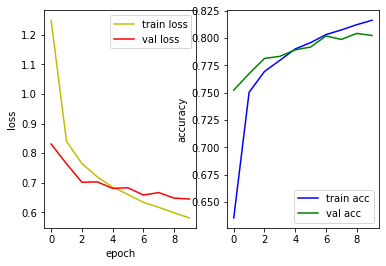

Epoch 1/10
807/807 [==============================] - 32s 35ms/step - loss: 1.6520 - accuracy: 0.5250 - val_loss: 0.9216 - val_accuracy: 0.7251
Epoch 2/10
807/807 [==============================] - 27s 33ms/step - loss: 0.9487 - accuracy: 0.7193 - val_loss: 0.8212 - val_accuracy: 0.7522
Epoch 3/10
807/807 [==============================] - 27s 34ms/step - loss: 0.8308 - accuracy: 0.7491 - val_loss: 0.7658 - val_accuracy: 0.7652
Epoch 4/10
807/807 [==============================] - 27s 33ms/step - loss: 0.7733 - accuracy: 0.7665 - val_loss: 0.7439 - val_accuracy: 0.7711
Epoch 5/10
807/807 [==============================] - 27s 34ms/step - loss: 0.7345 - accuracy: 0.7758 - val_loss: 0.7099 - val_accuracy: 0.7790
Epoch 6/10
807/807 [==============================] - 27s 34ms/step - loss: 0.6992 - accuracy: 0.7872 - val_loss: 0.7234 - val_accuracy: 0.7798
Epoch 7/10
807/807 [==============================] - 27s 34ms/step - loss: 0.6789 - accuracy: 0.7880 - val_loss: 0.7000 - val_accuracy:

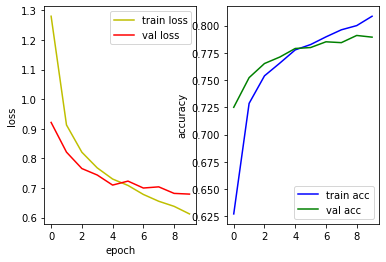

In [84]:
hyper_params = {
    'apply_attention': [True, False],
    'train_embedding_layer': [False],
    'dropout': [0.3],
    'weights': ['weight']#, 'norm_weight']
}

histories = dict()
test_scores = dict()

DEC_UNITS = 128
EPOCHS=10
BATCH_SIZE = 64

for a in hyper_params['apply_attention']:
    for te in hyper_params['train_embedding_layer']:
        for do in hyper_params['dropout']:
            for w in hyper_params['weights']:
                vocab_size, embedding_dim = w2v_model.weight.shape
                history, test_score = \
                    train_and_evaluate(vocab_size, 
                                       embedding_dim,
                                       DEC_UNITS,
                                       EPOCHS,
                                       BATCH_SIZE,
                                       w2v_model.weight,
                                       a,  # attention 적용할지?
                                       te, # embedding layer를 훈련시킬지, freezing시킬지?
                                       do, # dropout 비율
                                       len(label_encoder.classes_)) # class 개수
                model_name = f'{a}-{te}-{do}-{w}-{i}'
                histories[model_name] = history
                test_scores[model_name] = test_score

In [85]:
test_scores


{'True-False-0.3-weight-0': [0.6309701800346375, 0.8091106414794922],
 'False-False-0.3-weight-0': [0.6675344109535217, 0.7971438765525818]}